In [372]:
from torchvision.datasets import MNIST
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import numpy as np

from torch.utils.data import WeightedRandomSampler
import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import itertools

from deep_learning_at_scale.chapter_4.dataset import (
    SceneParsingDataset,
    PILToTensorUnScaled,
)

In [373]:
target_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            size=(256, 256),
            interpolation=0,  # InterpolationMode.NEAREST,
            antialias=True,
        ),
        PILToTensorUnScaled(),
    ]
)
dataset = SceneParsingDataset(set="train", target_transform=target_transforms)

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/Users/suneetamall/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
100%|██████████| 3/3 [00:00<00:00, 148.20it/s]


## Generate the stats per class of the Dataset


In [374]:
stats = []
for i, (_, target) in enumerate(dataset):
    record = {str(class_id): 1 for class_id in target.unique().tolist()}
    record["index"] = i
    stats.append(record)

df = pd.DataFrame(stats)
df.set_index("index")

,0,3,5,10,17,127,1,4,6,9,...,145,106,112,123,107,110,92,79,121,104
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20205,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20206,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20207,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Low prevalance classes are [55, 79, 80, 89, 92, 97, 100, 102, 104, 105, 106, 107, 108, 110, 112, 114, 115, 118, 121, 123, 127, 129, 131, 141]


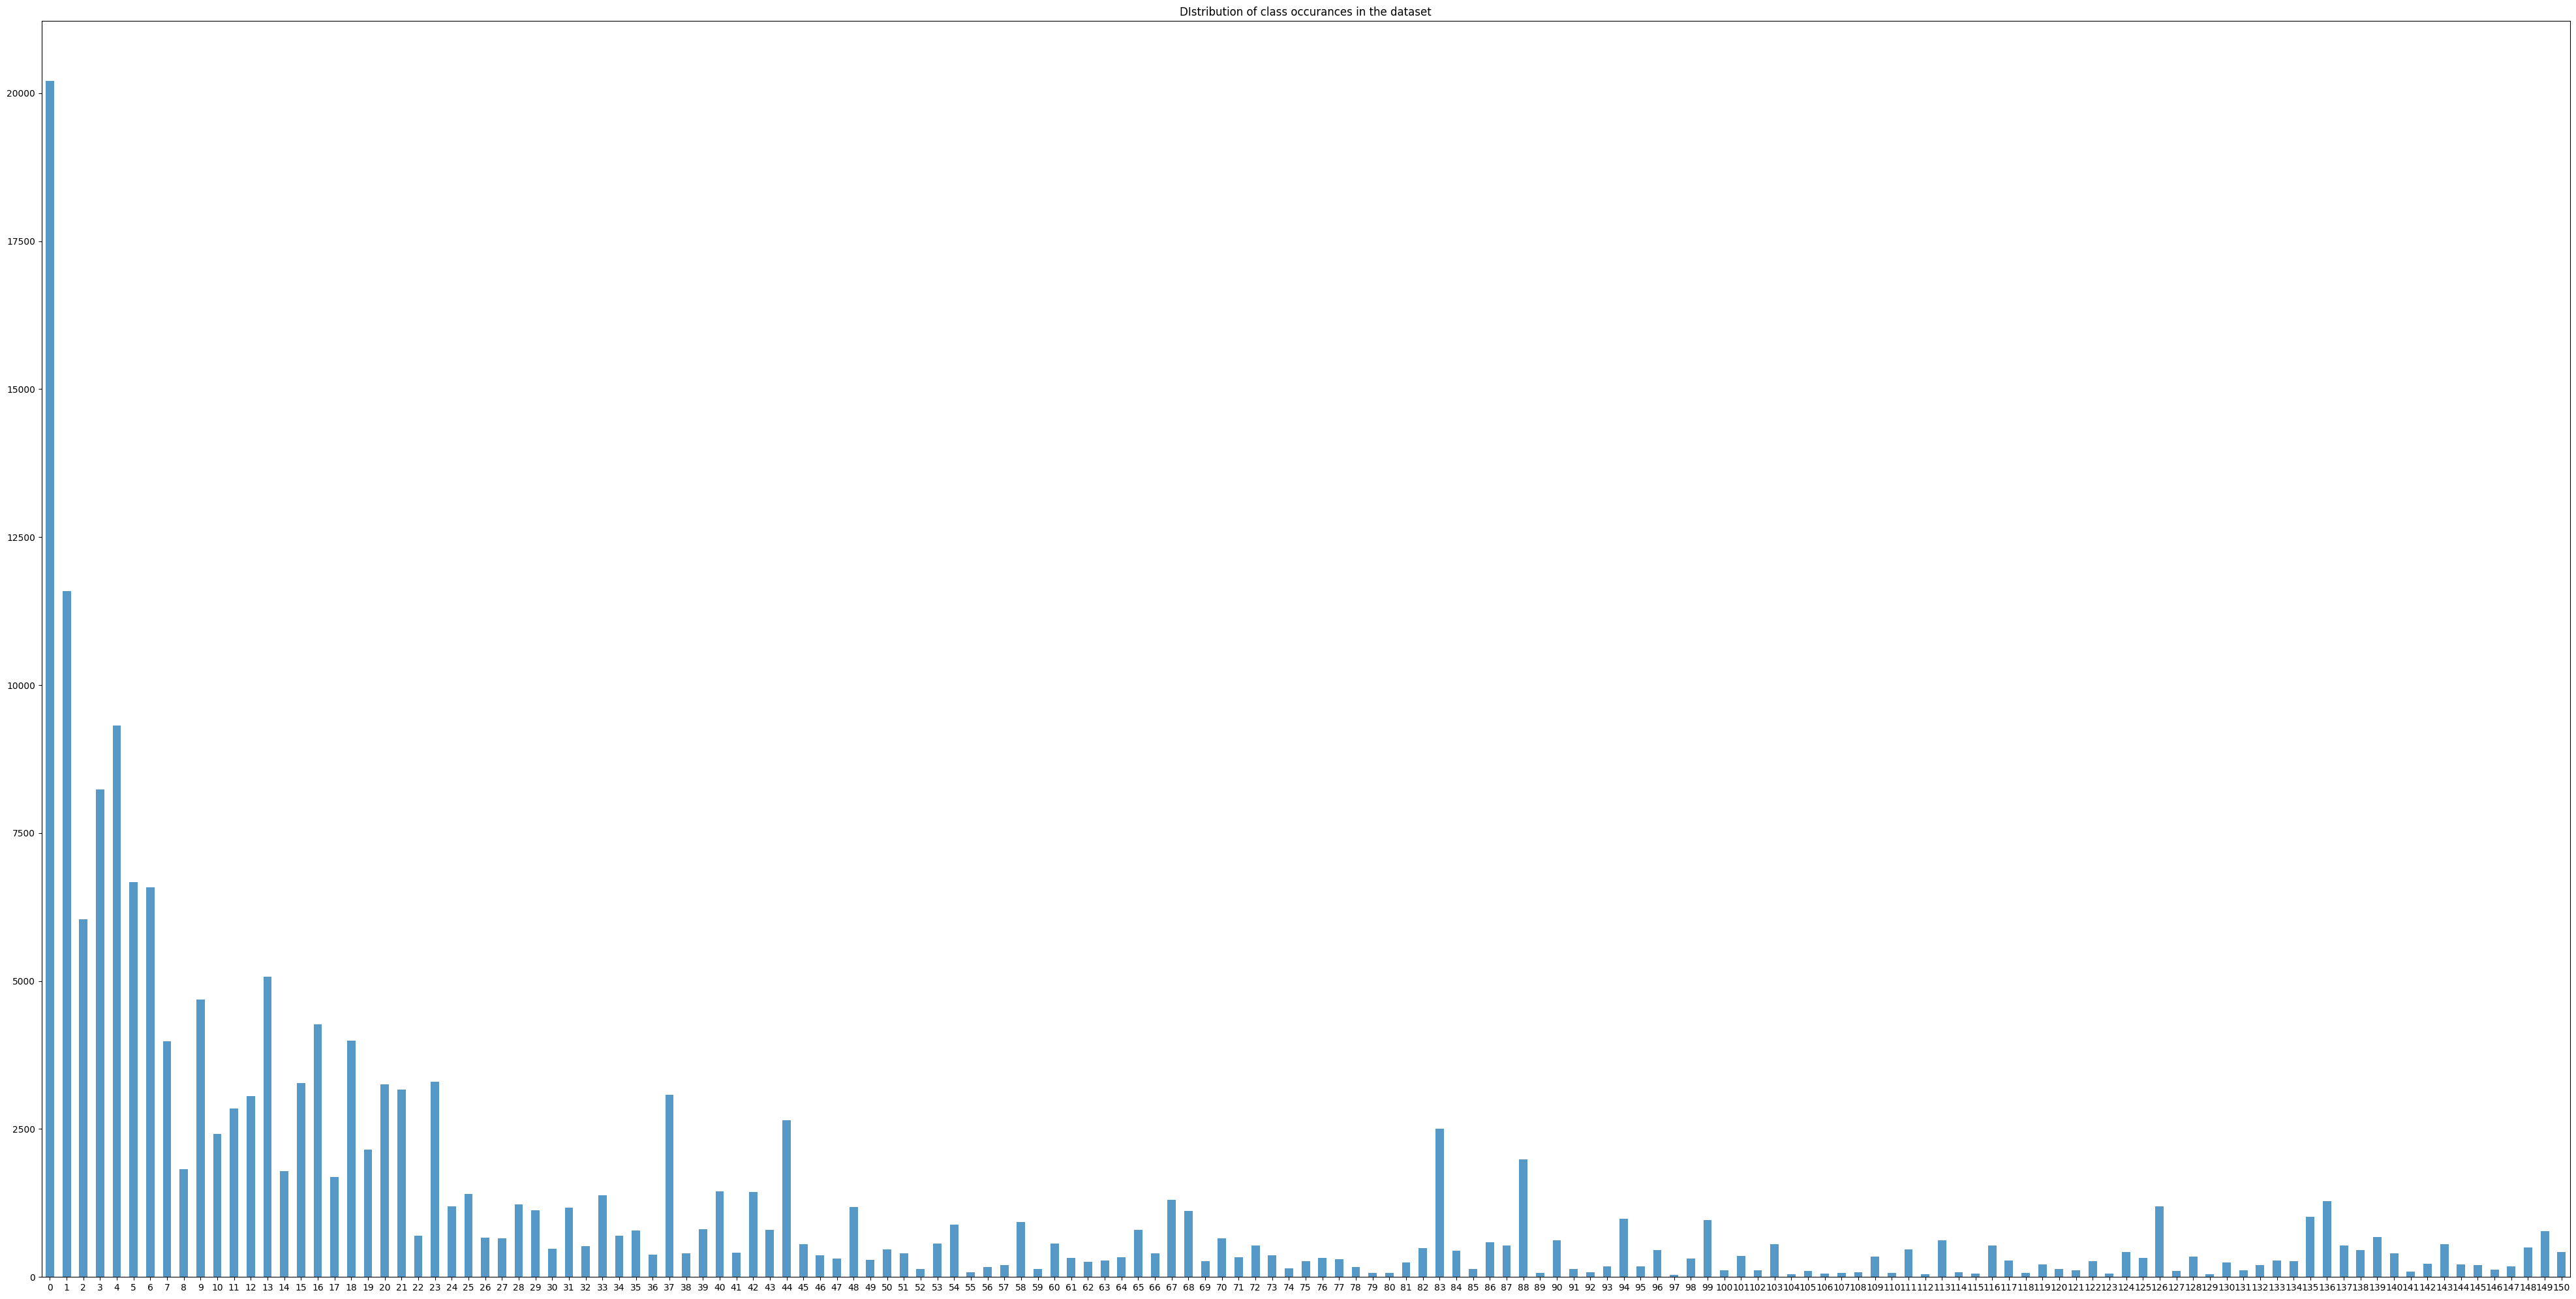

In [375]:
labels_df = df.drop(["index"], axis=1).sum(axis="rows")
labels_df.index = labels_df.index.astype(int)
labels_df.sort_index(inplace=True)
ax = labels_df.plot(kind="bar", figsize=(50, 25), rot=0, alpha=0.75, logy=False)
ax.set_title("DIstribution of class occurances in the dataset")

low_prevelance_class_ids = list(labels_df[1 / labels_df > 0.008].index)
print("Low prevalance classes are", low_prevelance_class_ids)

## Create Dataset and Dataloader to explore batch statistics per class

In [376]:
class SceneParsingStatsDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.df = df.drop(["index"], axis=1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        class_ids = row.index.astype(int).to_numpy()
        class_presence = row.values.astype(int)
        class_ids = class_ids[np.where(class_presence == 1)[0]].tolist()
        return idx, class_ids


def padding_collator(data):
    idx, class_ids = zip(*data)
    padded_class_ids = list(zip(*itertools.zip_longest(*class_ids, fillvalue=-1)))
    return torch.as_tensor(idx).long(), torch.as_tensor(padded_class_ids).int()


stats_loader = DataLoader(
    SceneParsingStatsDataset(df),
    collate_fn=padding_collator,
    shuffle=True,
    batch_size=100,
)

In [377]:
def summarize_batches(dataloader: DataLoader):
    seen_stats = []
    for batch_idx, (_, class_ids_present) in enumerate(dataloader):
        stats = {"batch_index": batch_idx}
        p_cids, counts = torch.unique(
            class_ids_present, sorted=True, return_counts=True
        )
        for c_idx, c_id in enumerate(p_cids[1:]):
            stats[c_id.item()] = counts[c_idx + 1].item()
        seen_stats.append(stats)
    return pd.DataFrame(seen_stats).set_index("batch_index")


stats_df = summarize_batches(stats_loader)

Text(0.5, 1.0, 'Distribution of classes across batches')

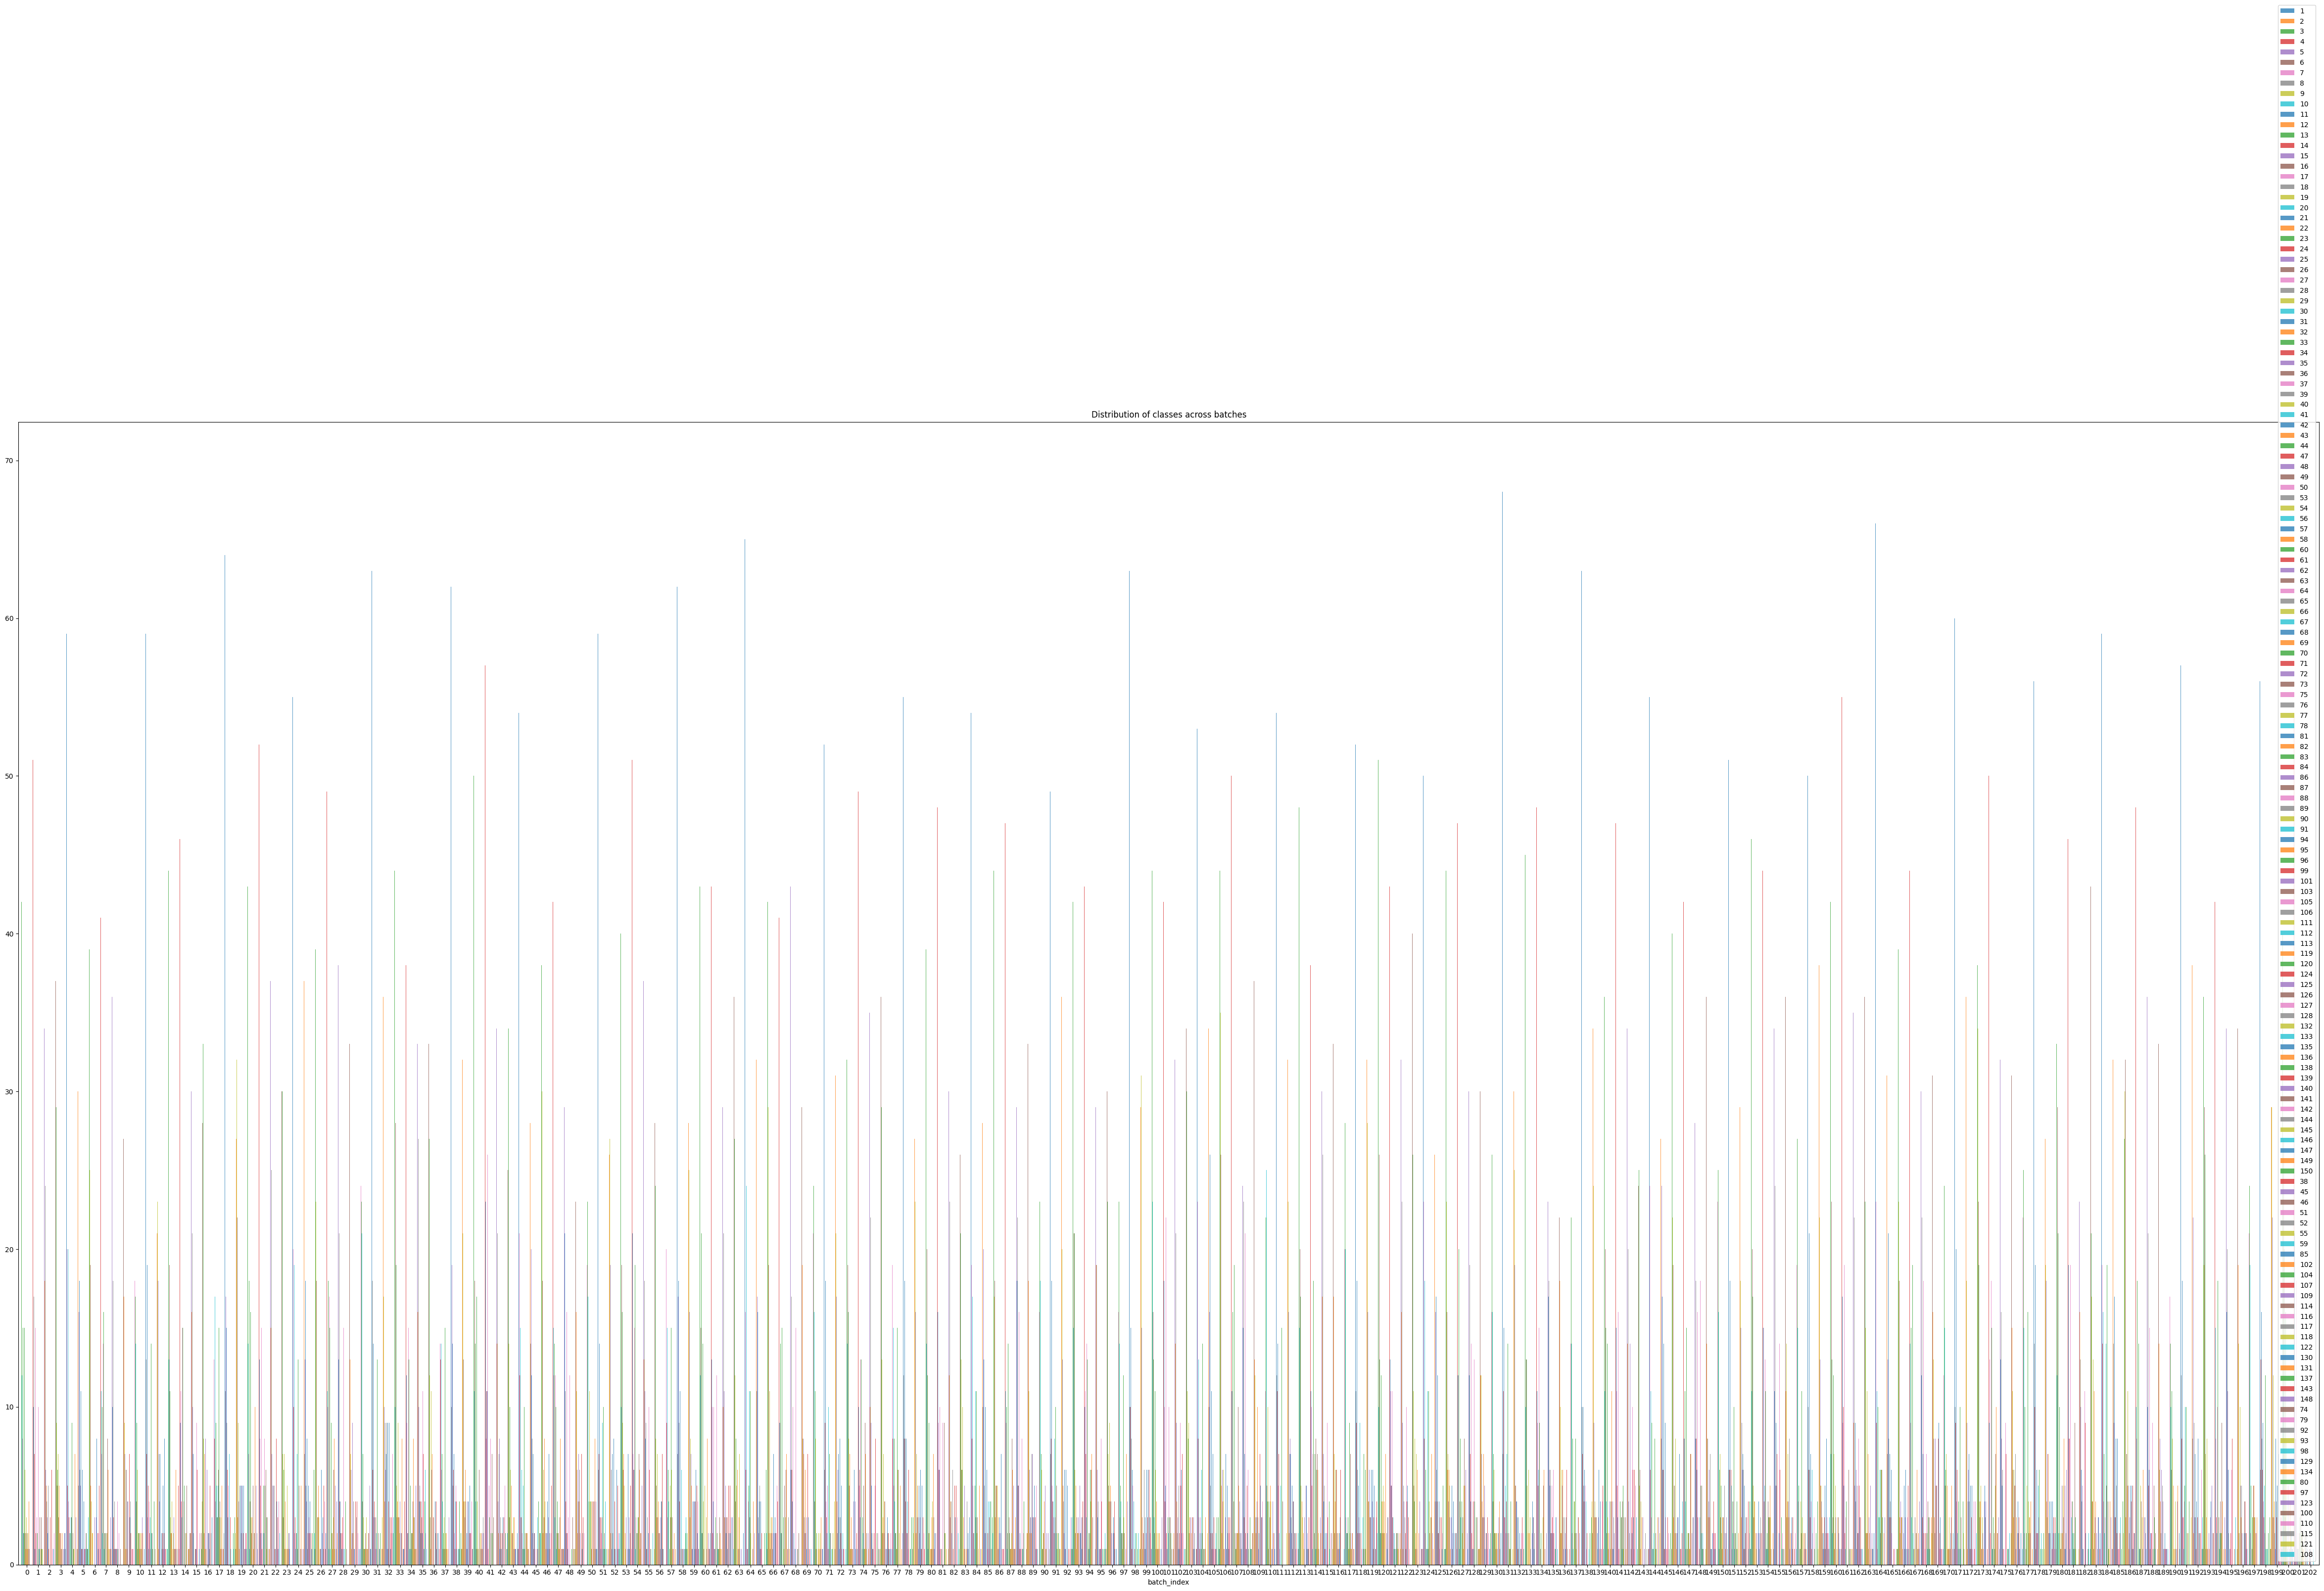

In [378]:
ax = stats_df.loc[:, 1:].plot(
    kind="bar", figsize=(60, 30), rot=0, alpha=0.75, logy=False, width=1
)
ax.set_title("Distribution of classes across batches")

## Create WeightedRandomSampler using Class Probability

In [379]:
weights_df = df.drop(["index"], axis=1)
global_count_by_classes = weights_df.sum(axis="rows")
global_class_weights = 1 / global_count_by_classes
sampler_weights_df = global_class_weights * weights_df
sample_weights = sampler_weights_df.sum(axis="columns")

sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(df), replacement=True
)
weighted_loader = DataLoader(
    SceneParsingStatsDataset(df),
    collate_fn=padding_collator,
    batch_size=100,
    sampler=sampler,
)

stats_weighted_df = summarize_batches(weighted_loader)

Text(0.5, 1.0, 'Distribution of classes across batches when WeightedRandomSampler is used.')

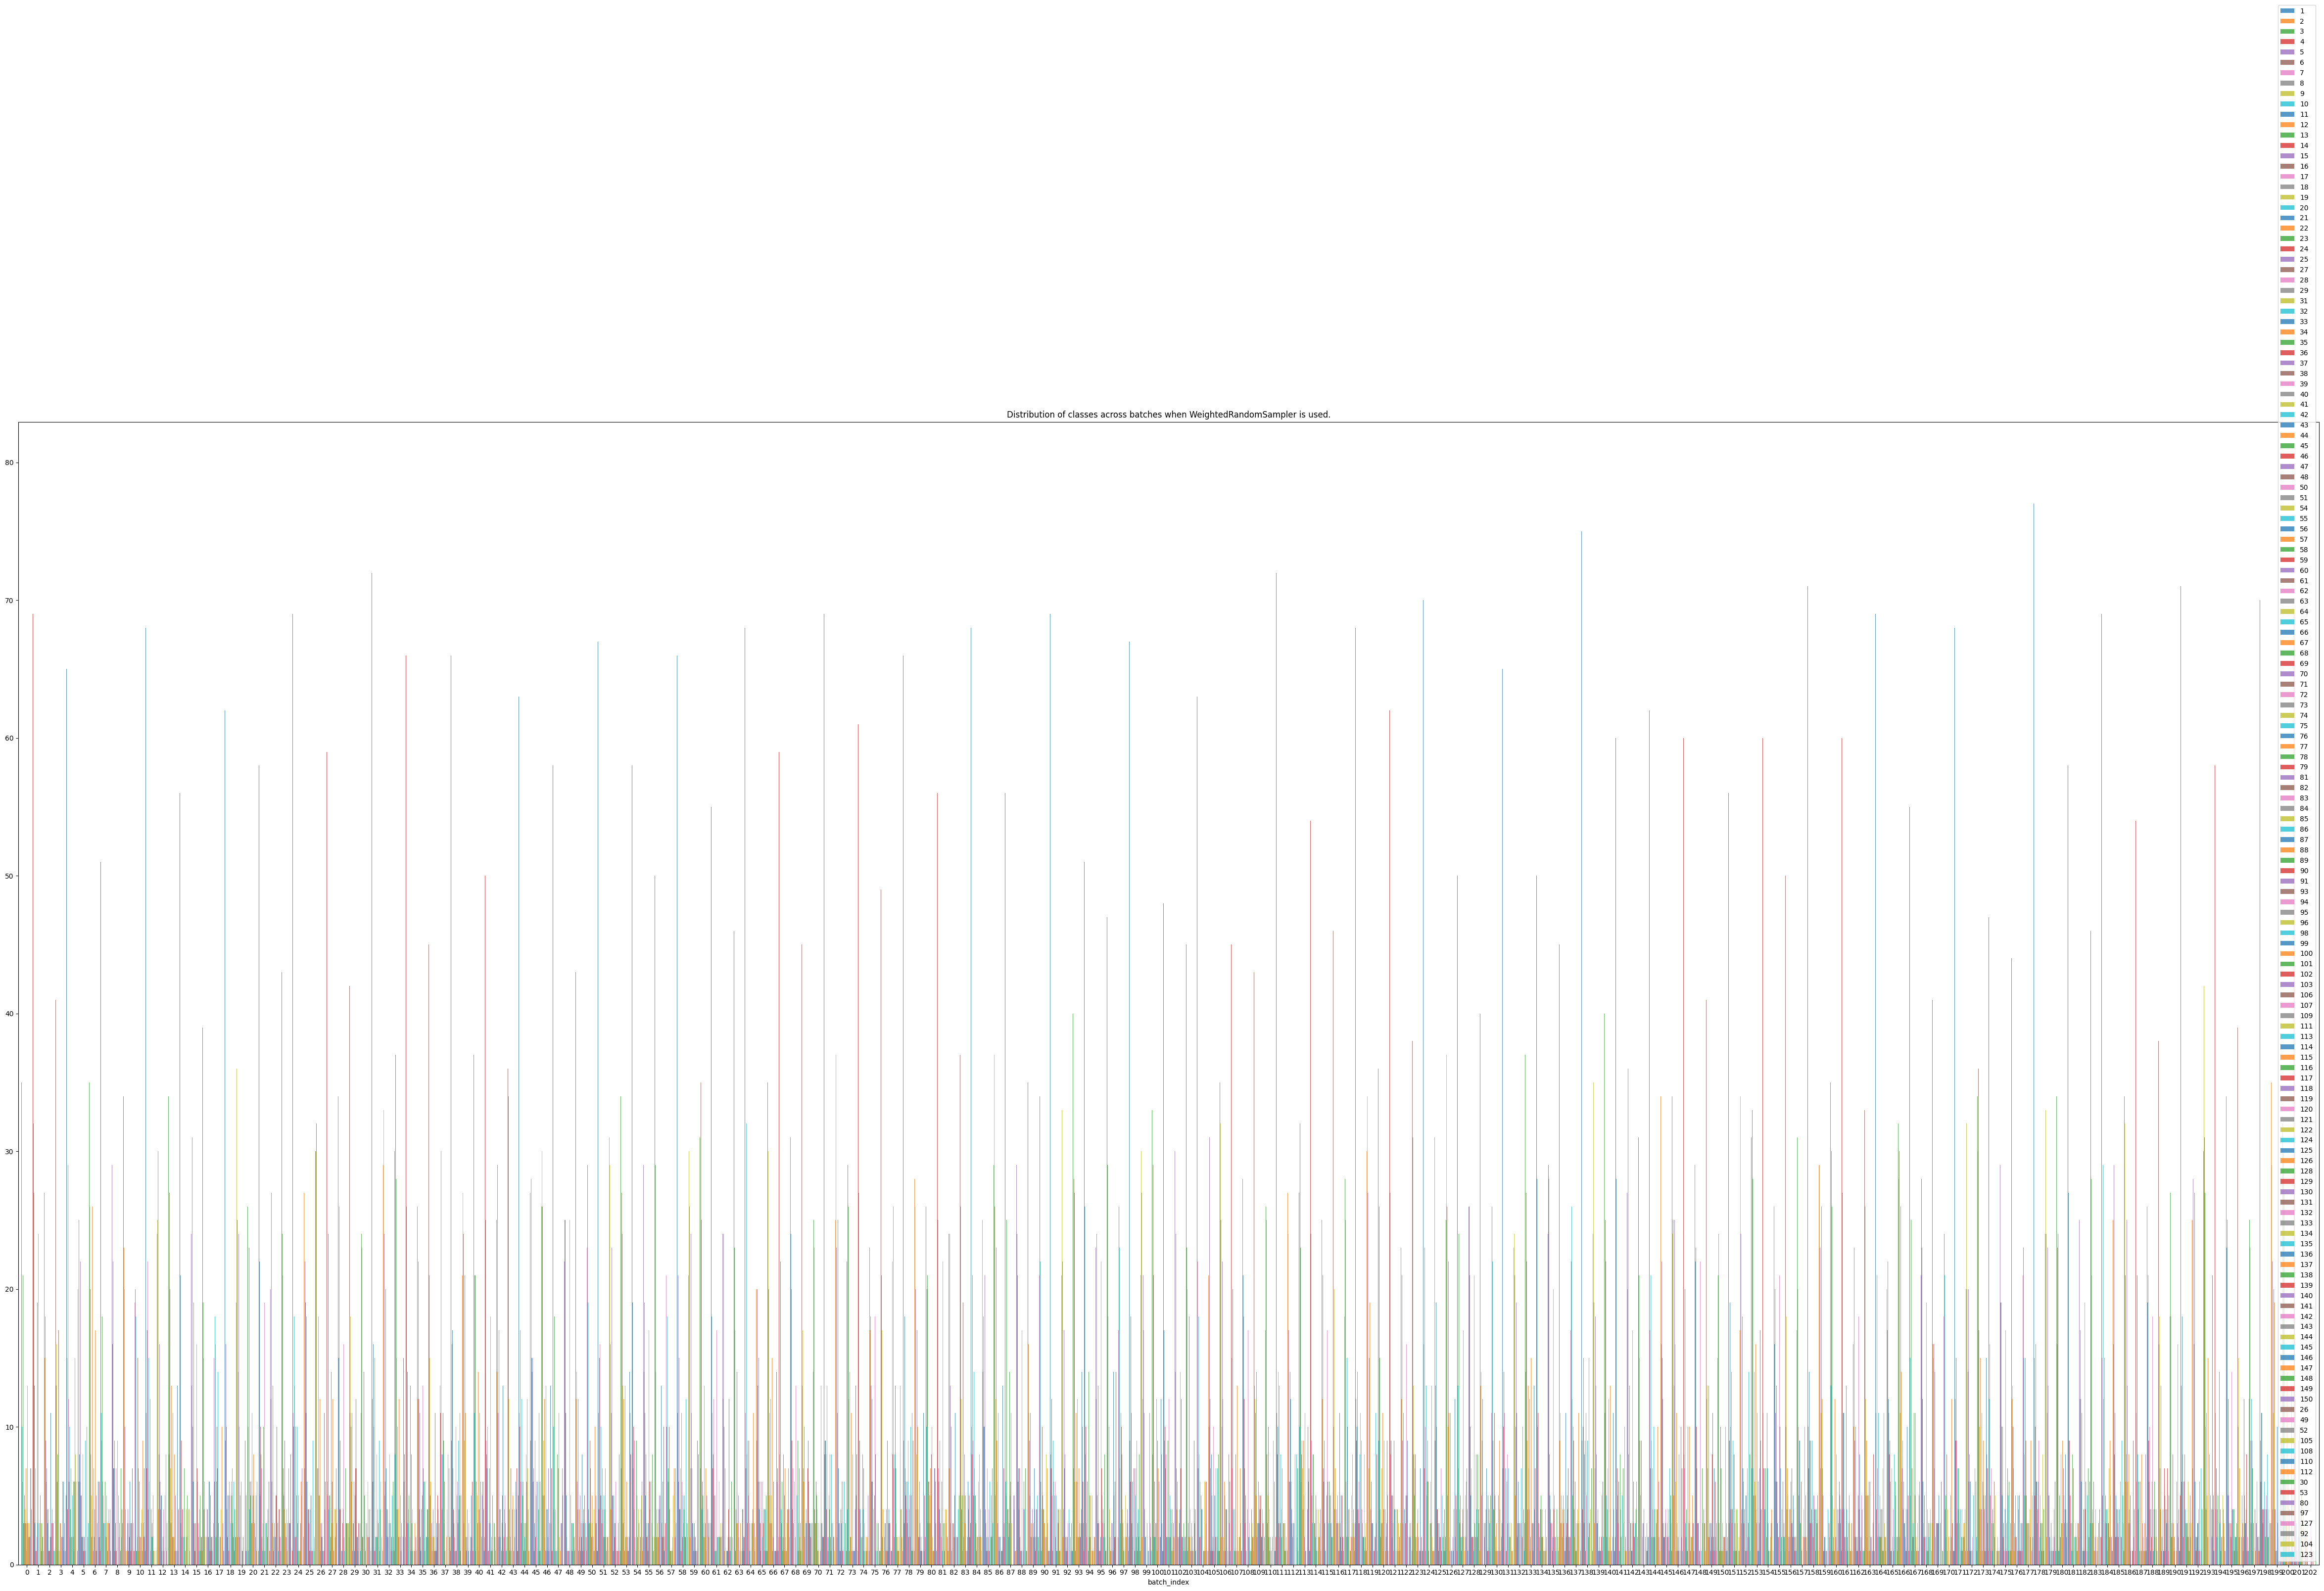

In [380]:
ax = stats_weighted_df.loc[:, 1:].plot(
    kind="bar", figsize=(60, 30), rot=0, alpha=0.75, logy=False, width=1
)
ax.set_title(
    "Distribution of classes across batches when WeightedRandomSampler is used."
)

Text(0.5, 1.0, 'Difference in class distribution across batches when the Random and WeightedRandomSampler are used.')

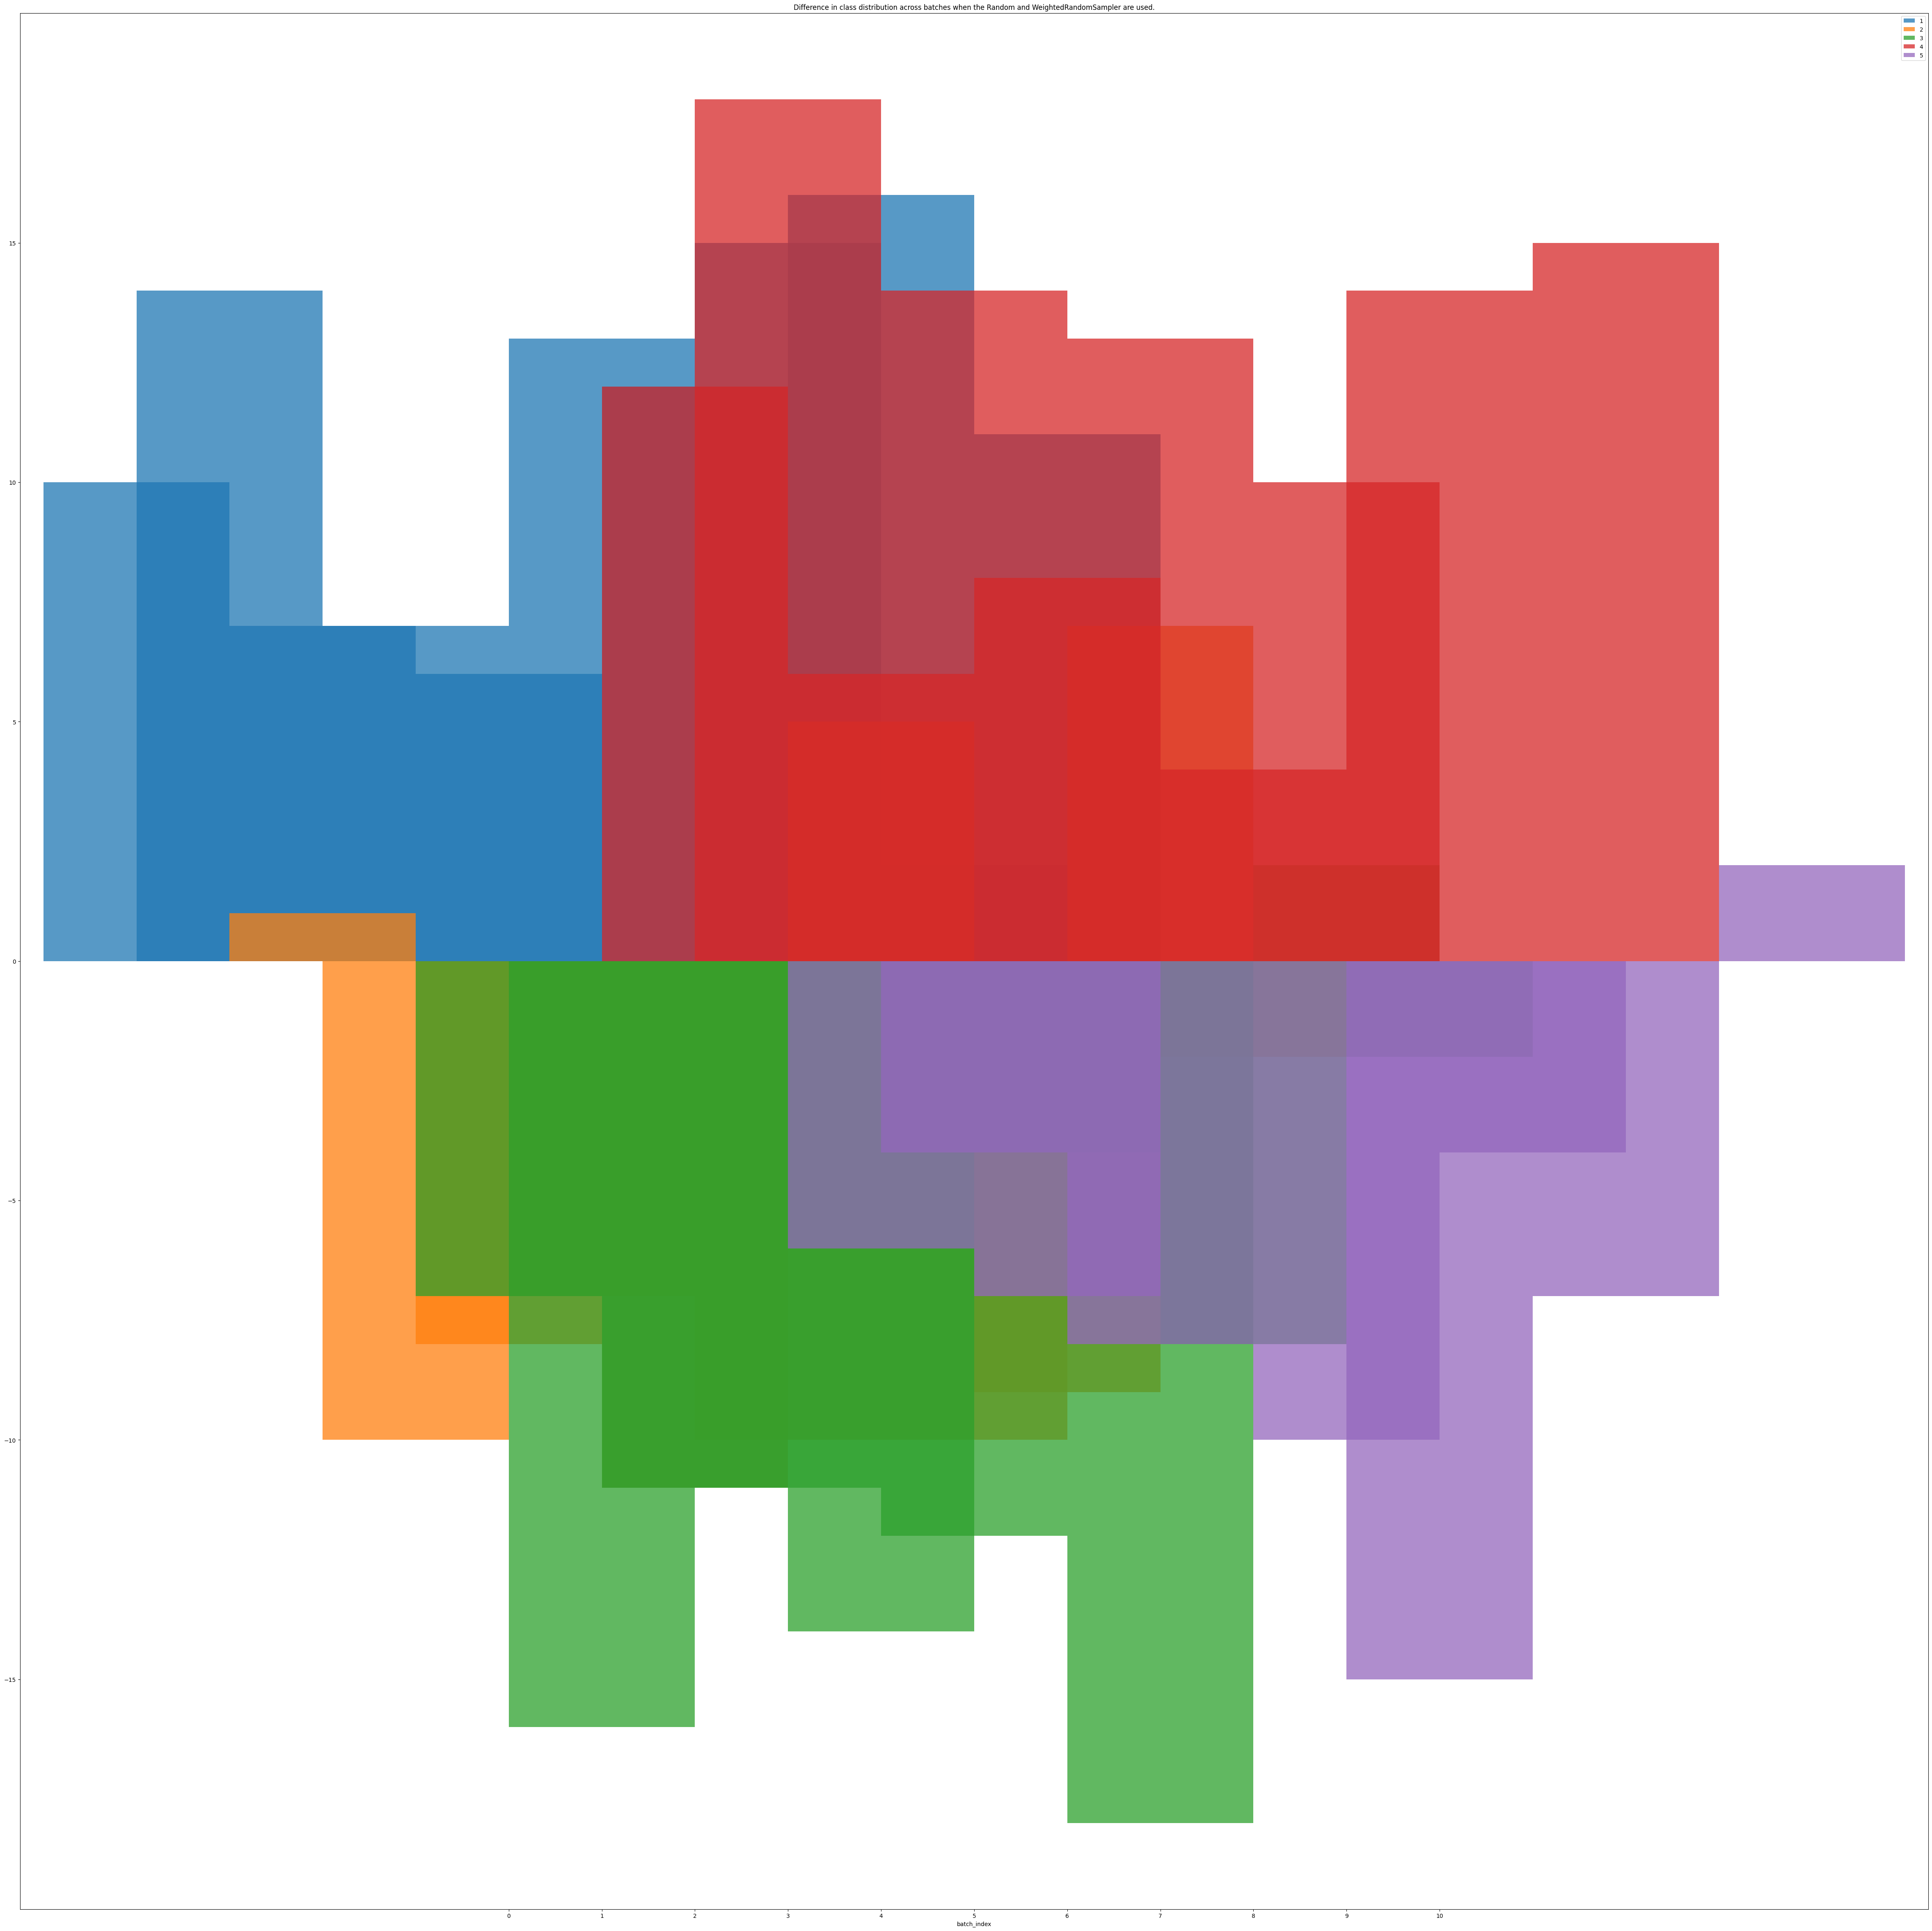

In [381]:
ax = (
    (stats_weighted_df - stats_df)
    .loc[:10, 1:5]
    .plot(
        kind="bar",
        figsize=(60, 60),
        rot=0,
        alpha=0.75,
        logy=False,
        width=10,
    )
)
ax.set_title(
    "Difference in class distribution across batches when the Random and WeightedRandomSampler are used."
)

<Axes: xlabel='batch_index'>

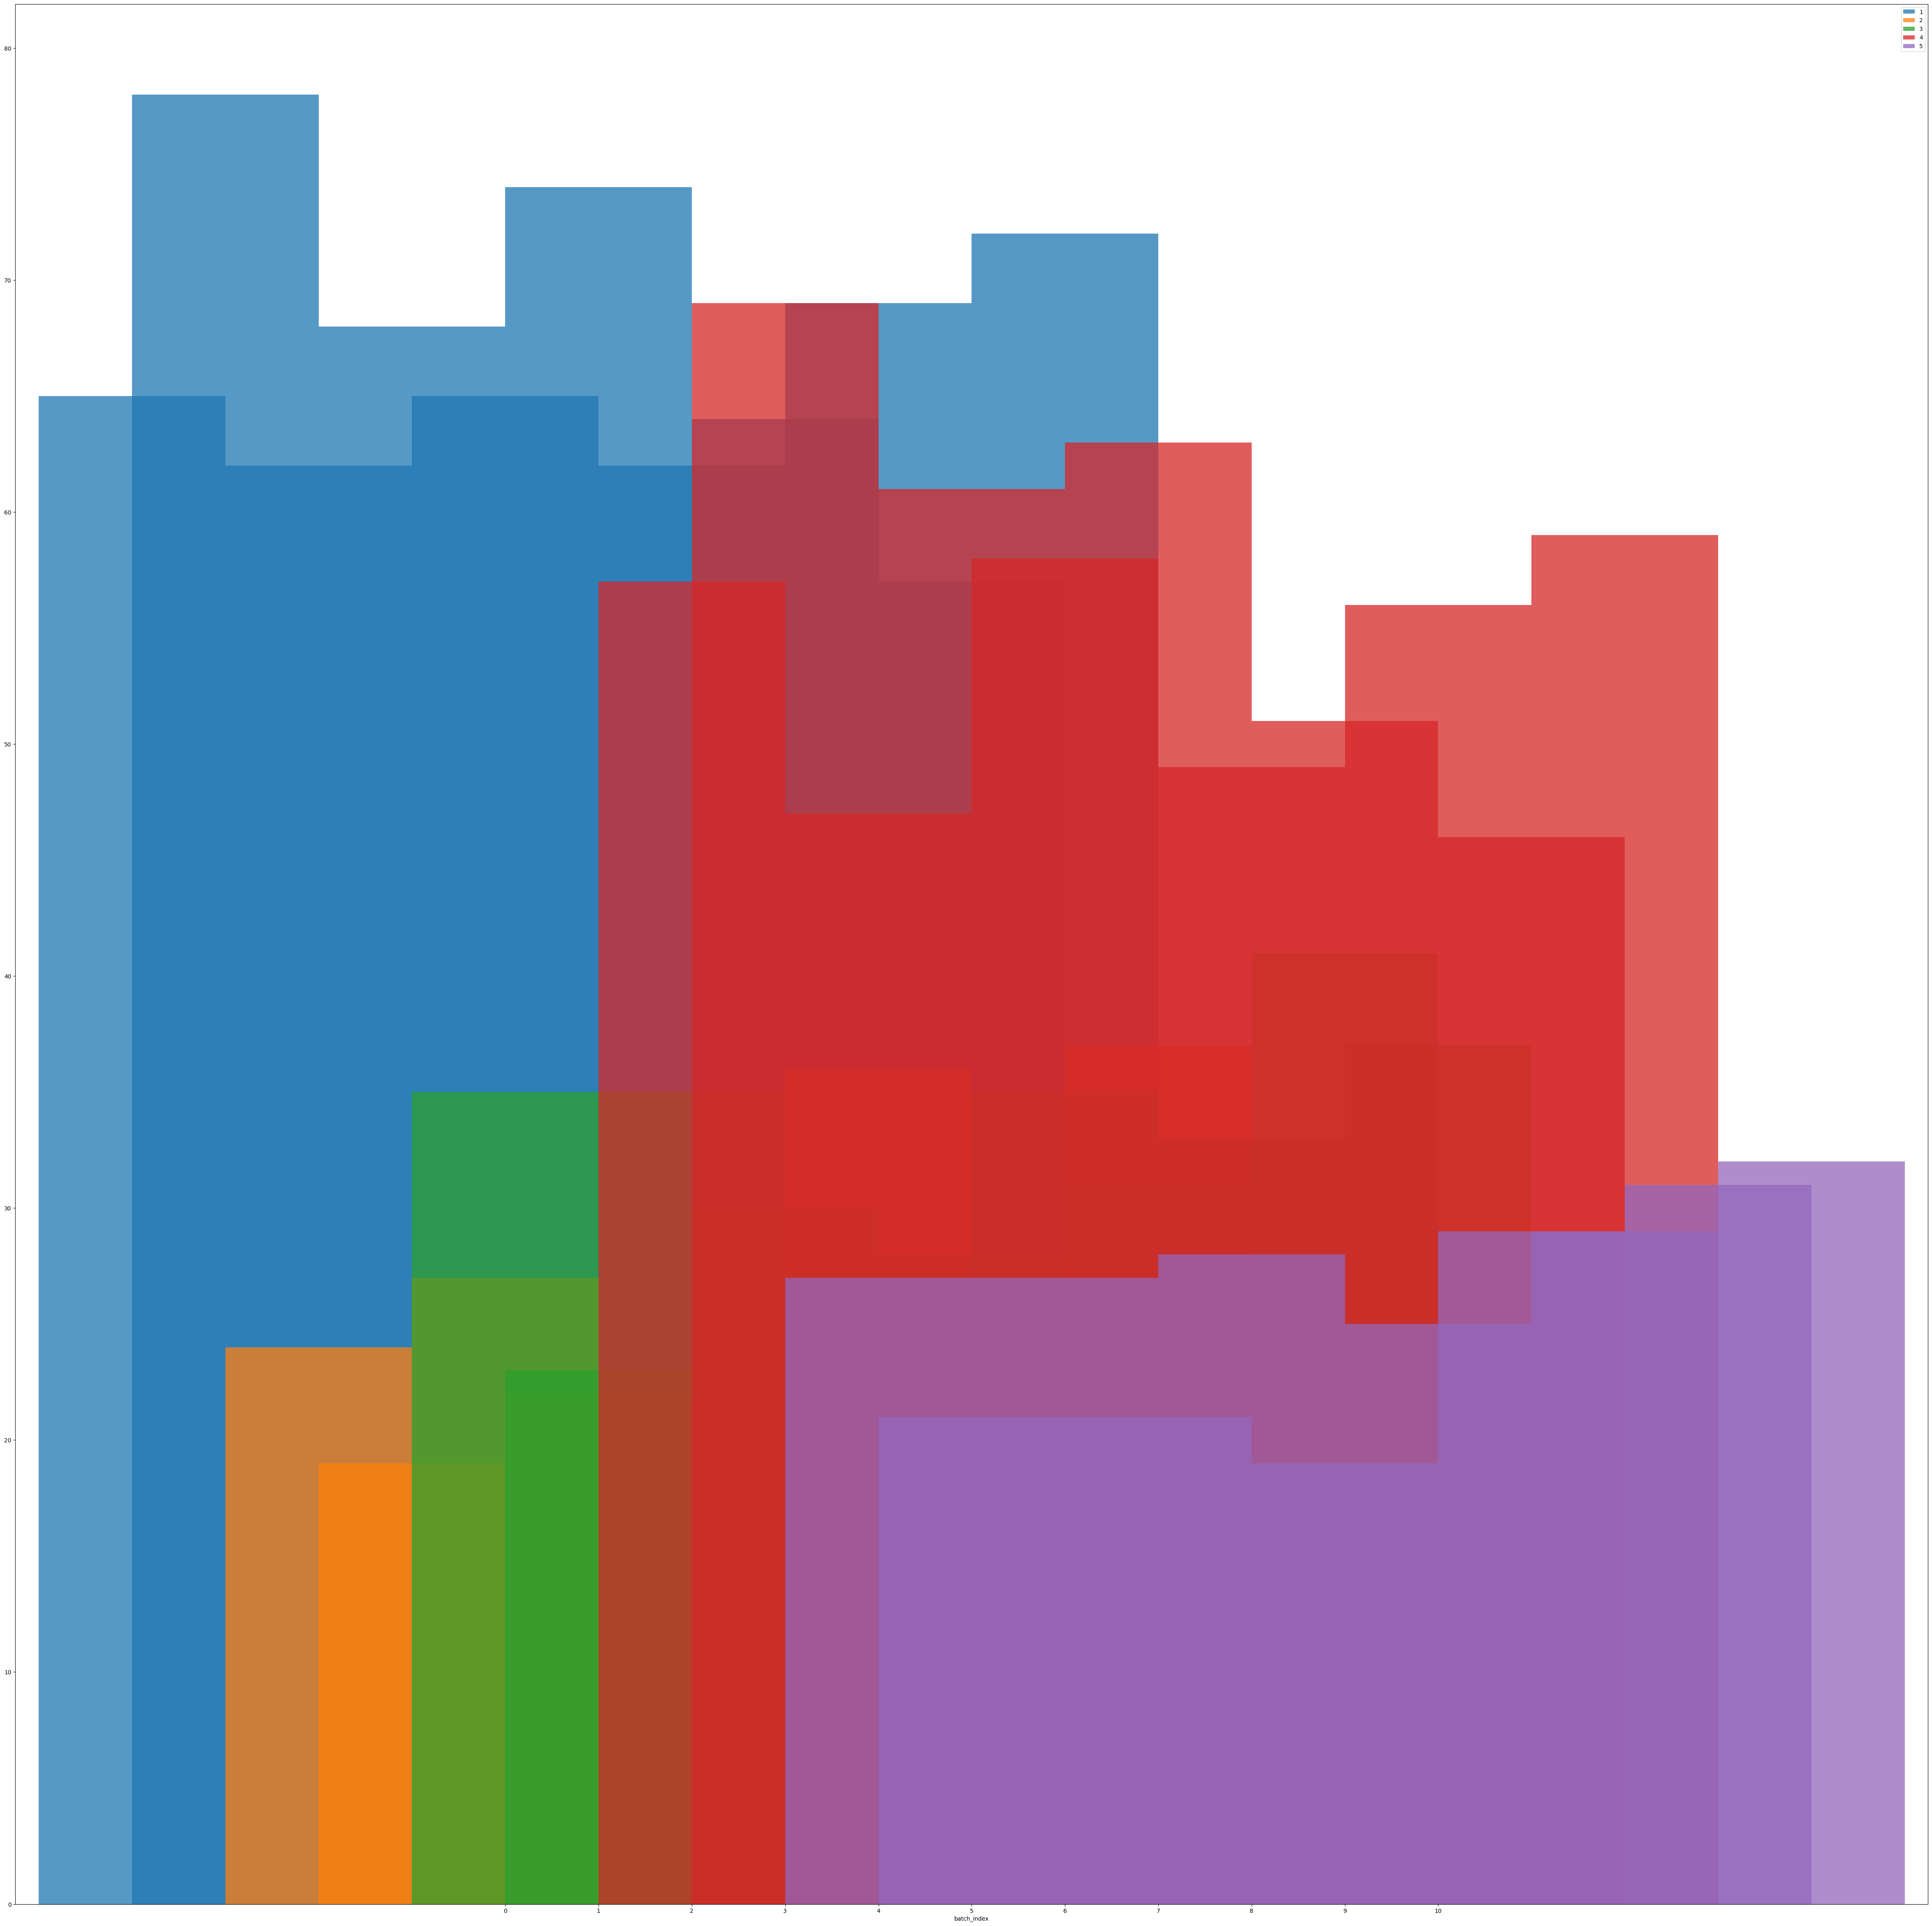

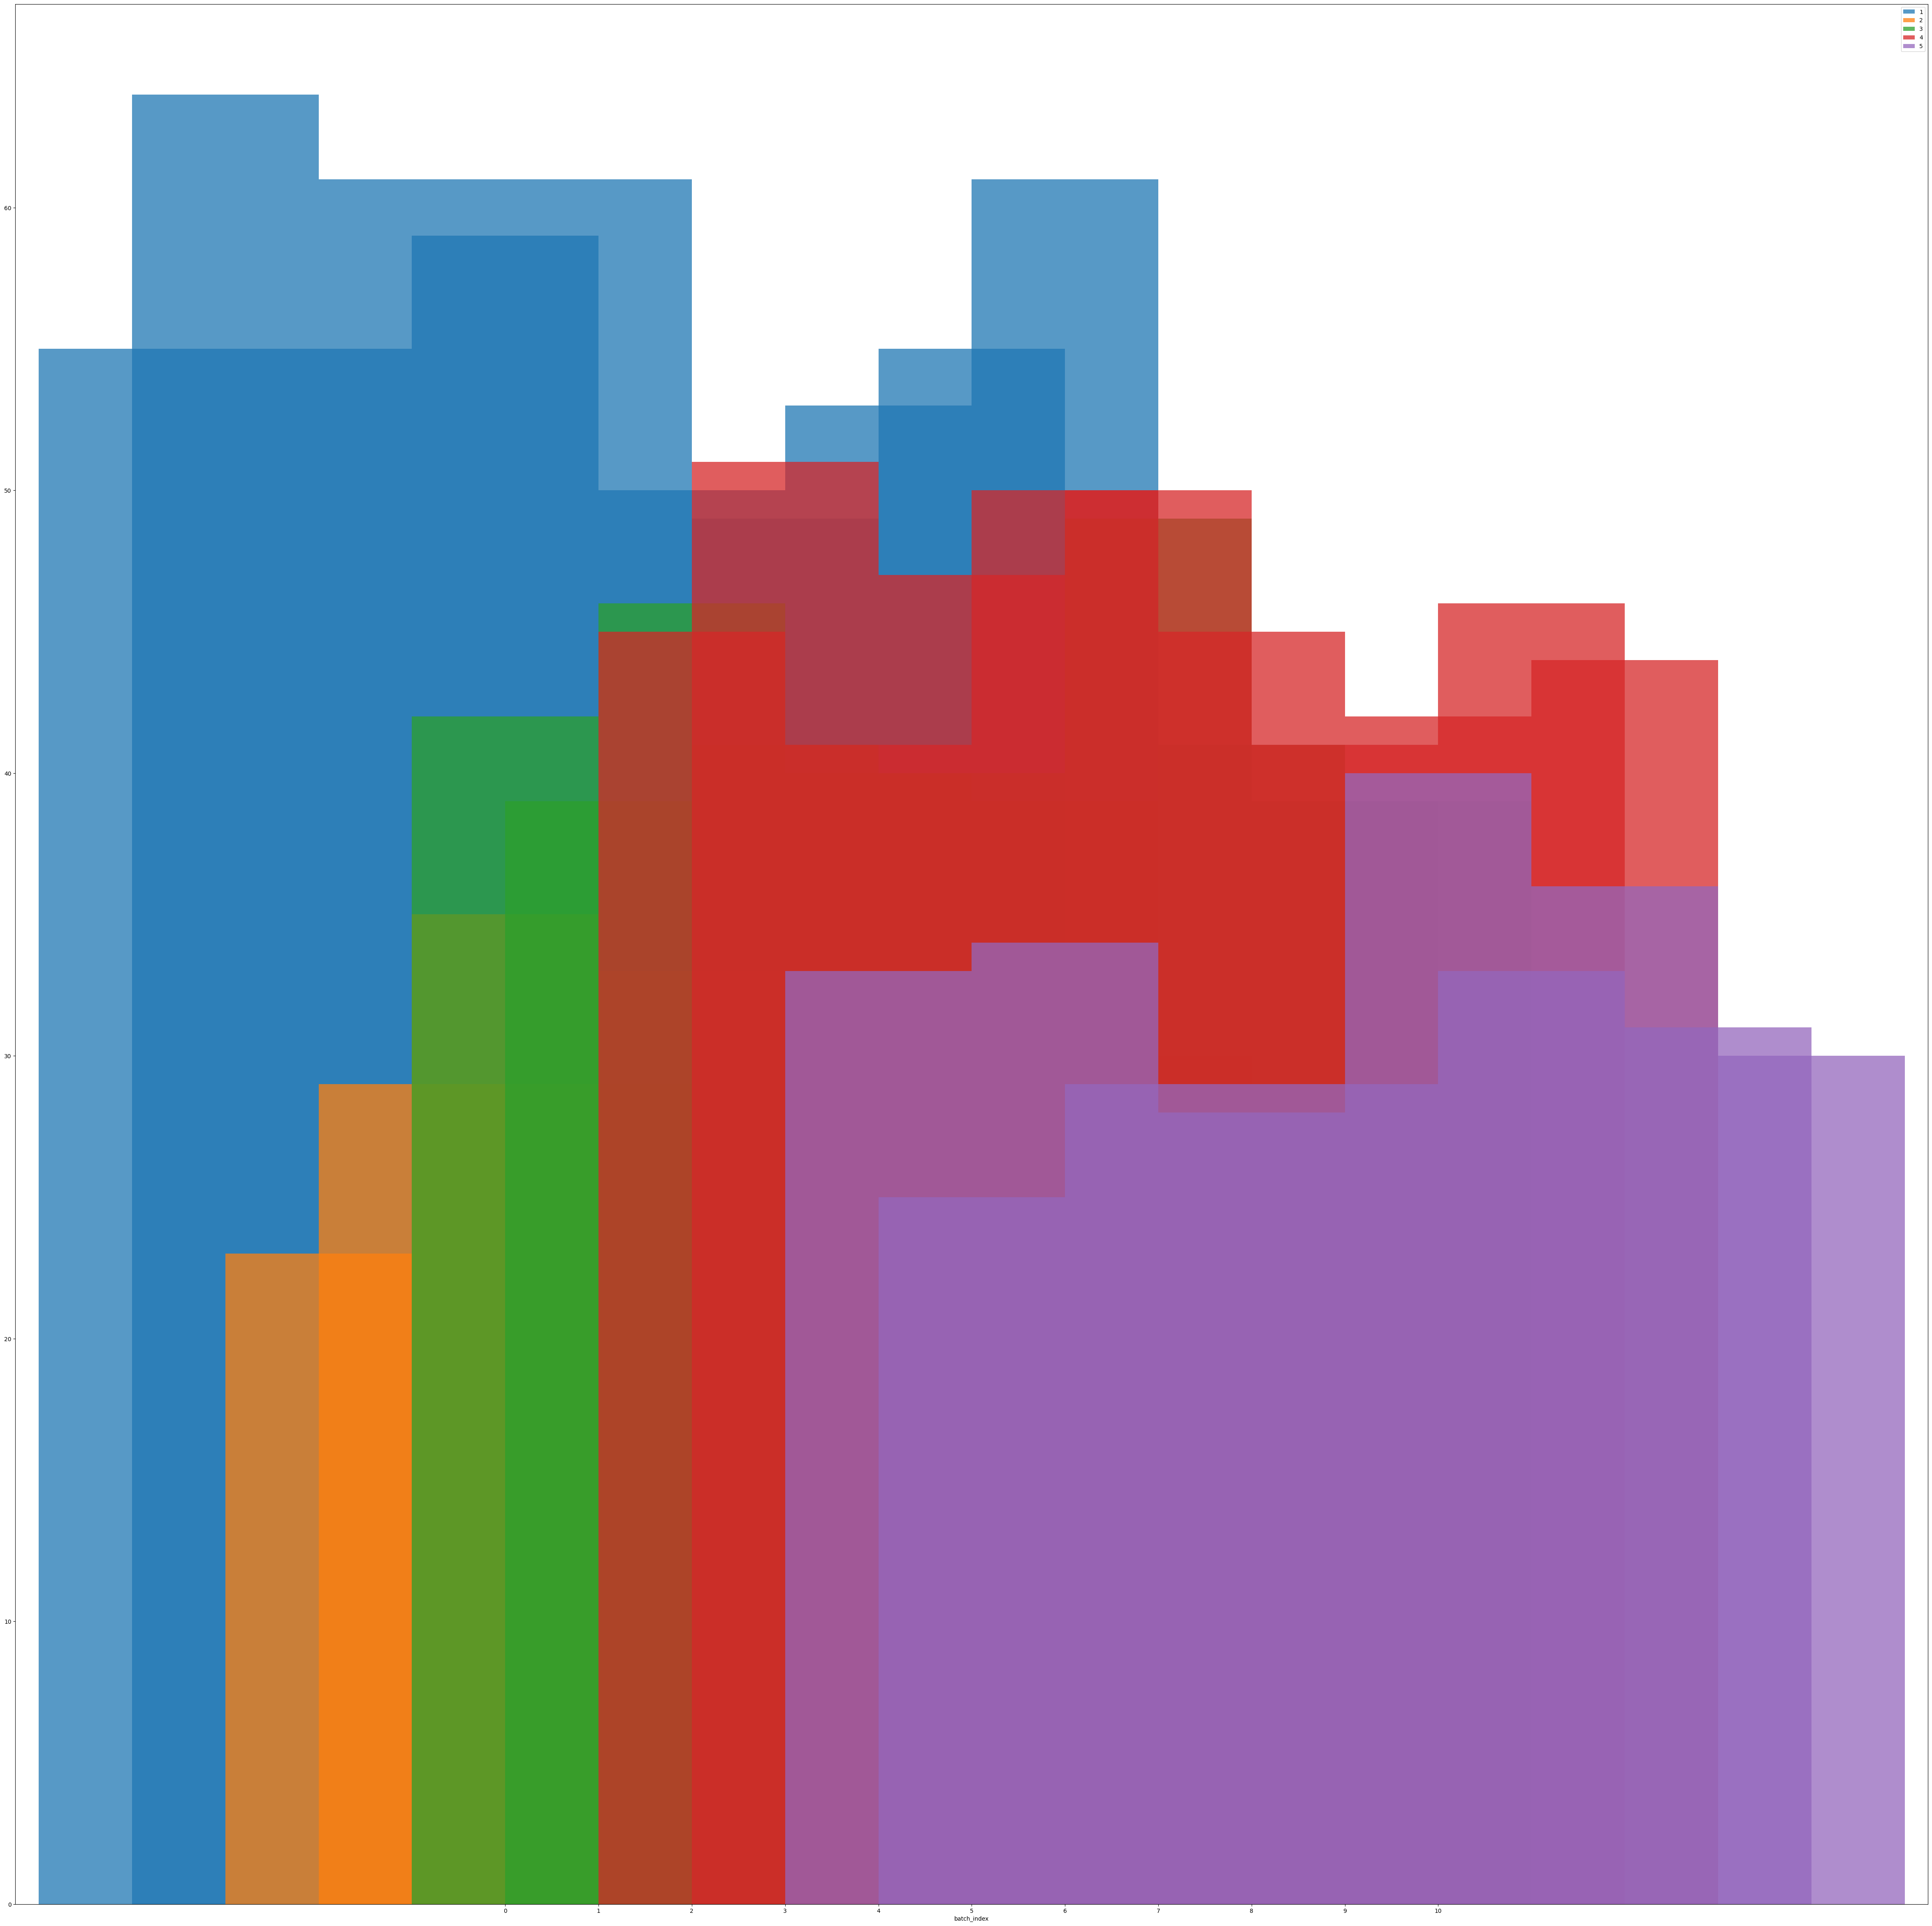

In [382]:
stats_weighted_df.loc[:10, 1:5].plot(
    kind="bar",
    figsize=(60, 60),
    rot=0,
    alpha=0.75,
    logy=False,
    width=10,
)
stats_df.loc[:10, 1:5].plot(
    kind="bar",
    figsize=(60, 60),
    rot=0,
    alpha=0.75,
    logy=False,
    width=10,
)

## Amplified Weighted Random Sampler

Very low prevelance classes are given higher weights than other counter parts.

Text(0.5, 1.0, 'Distribution of classes across batches when Amplified WeightedRandomSampler is used.')

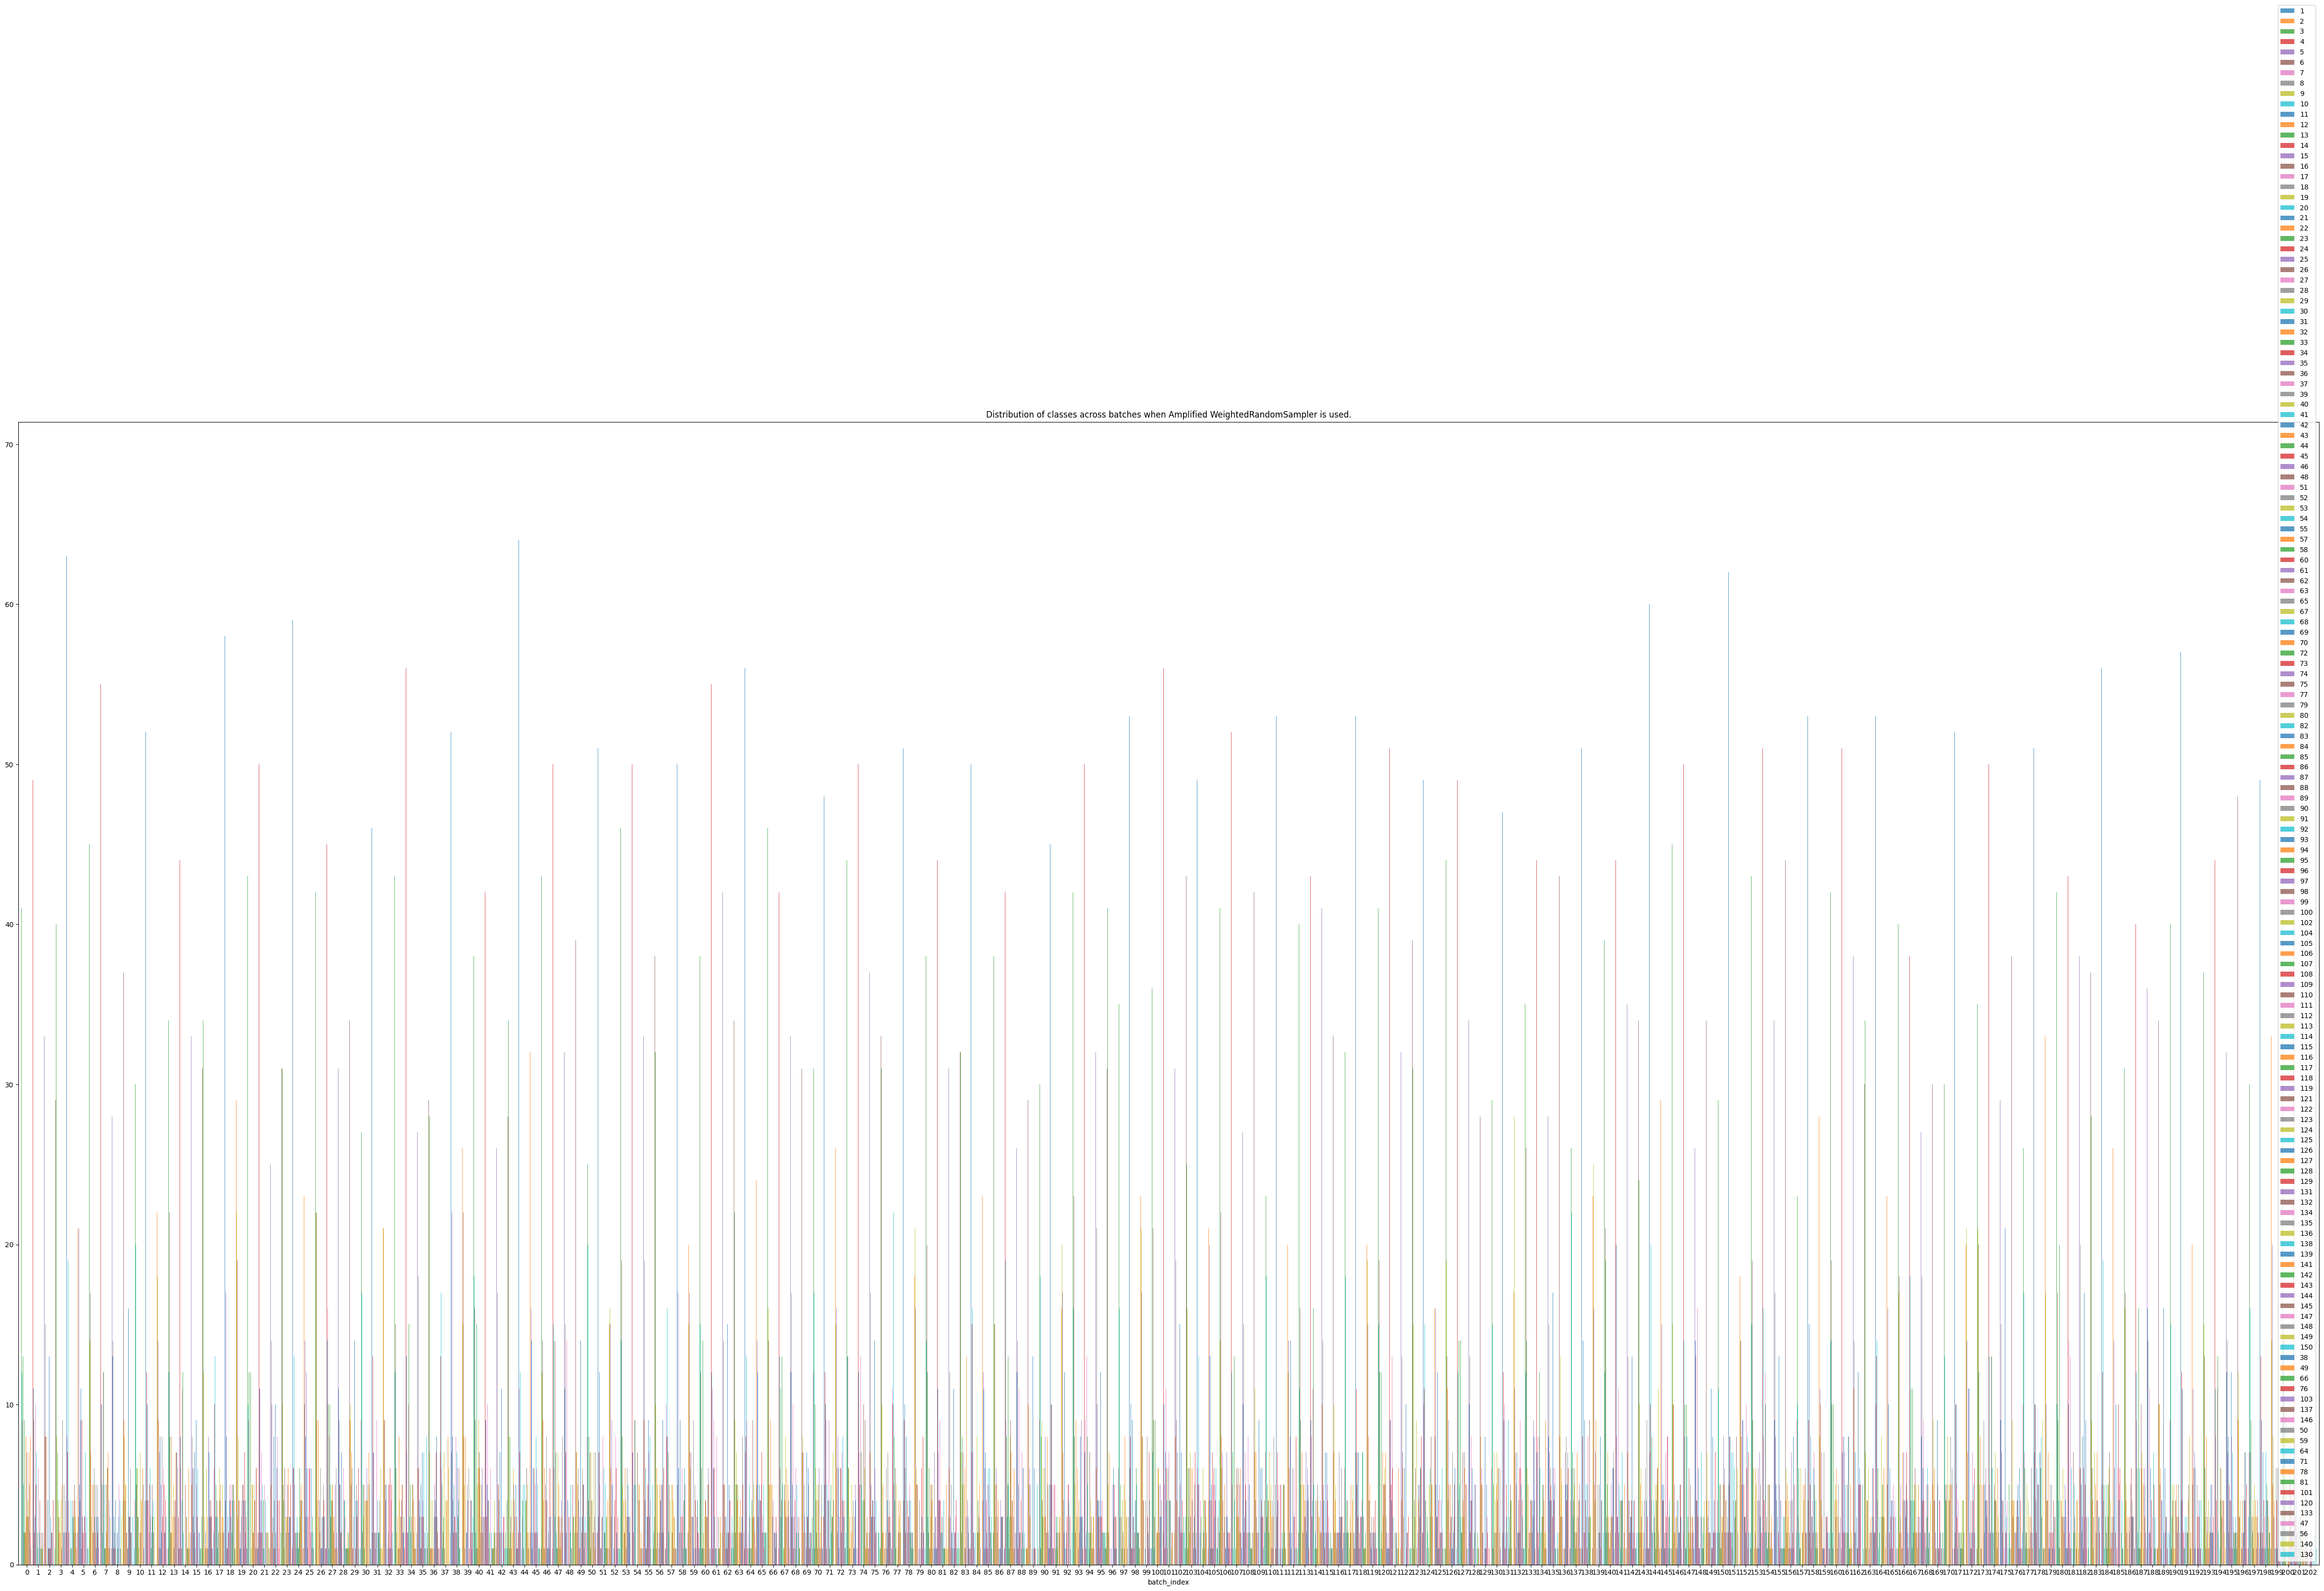

In [383]:
multiplied_class_weights = np.where(
    global_class_weights > 0.008, global_class_weights * 100, global_class_weights
)
multiplier_weights_df = multiplied_class_weights * weights_df
multiplier_sample_weights = multiplier_weights_df.sum(axis="columns")

multiplier_sampler = WeightedRandomSampler(
    weights=multiplier_sample_weights, num_samples=len(weights_df), replacement=True
)
multiplier_weighted_loader = DataLoader(
    SceneParsingStatsDataset(df),
    collate_fn=padding_collator,
    batch_size=100,
    sampler=multiplier_sampler,
)

multiplier_stats_weighted_df = summarize_batches(multiplier_weighted_loader)

ax = multiplier_stats_weighted_df.loc[:, 1:].plot(
    kind="bar", figsize=(60, 30), rot=0, alpha=0.75, logy=False, width=1
)
ax.set_title(
    "Distribution of classes across batches when Amplified WeightedRandomSampler is used."
)

# PowerSet Sampling

Text(0.5, 1.0, 'Distribution of classes across batches when Powerset WeightedRandomSampler is used.')

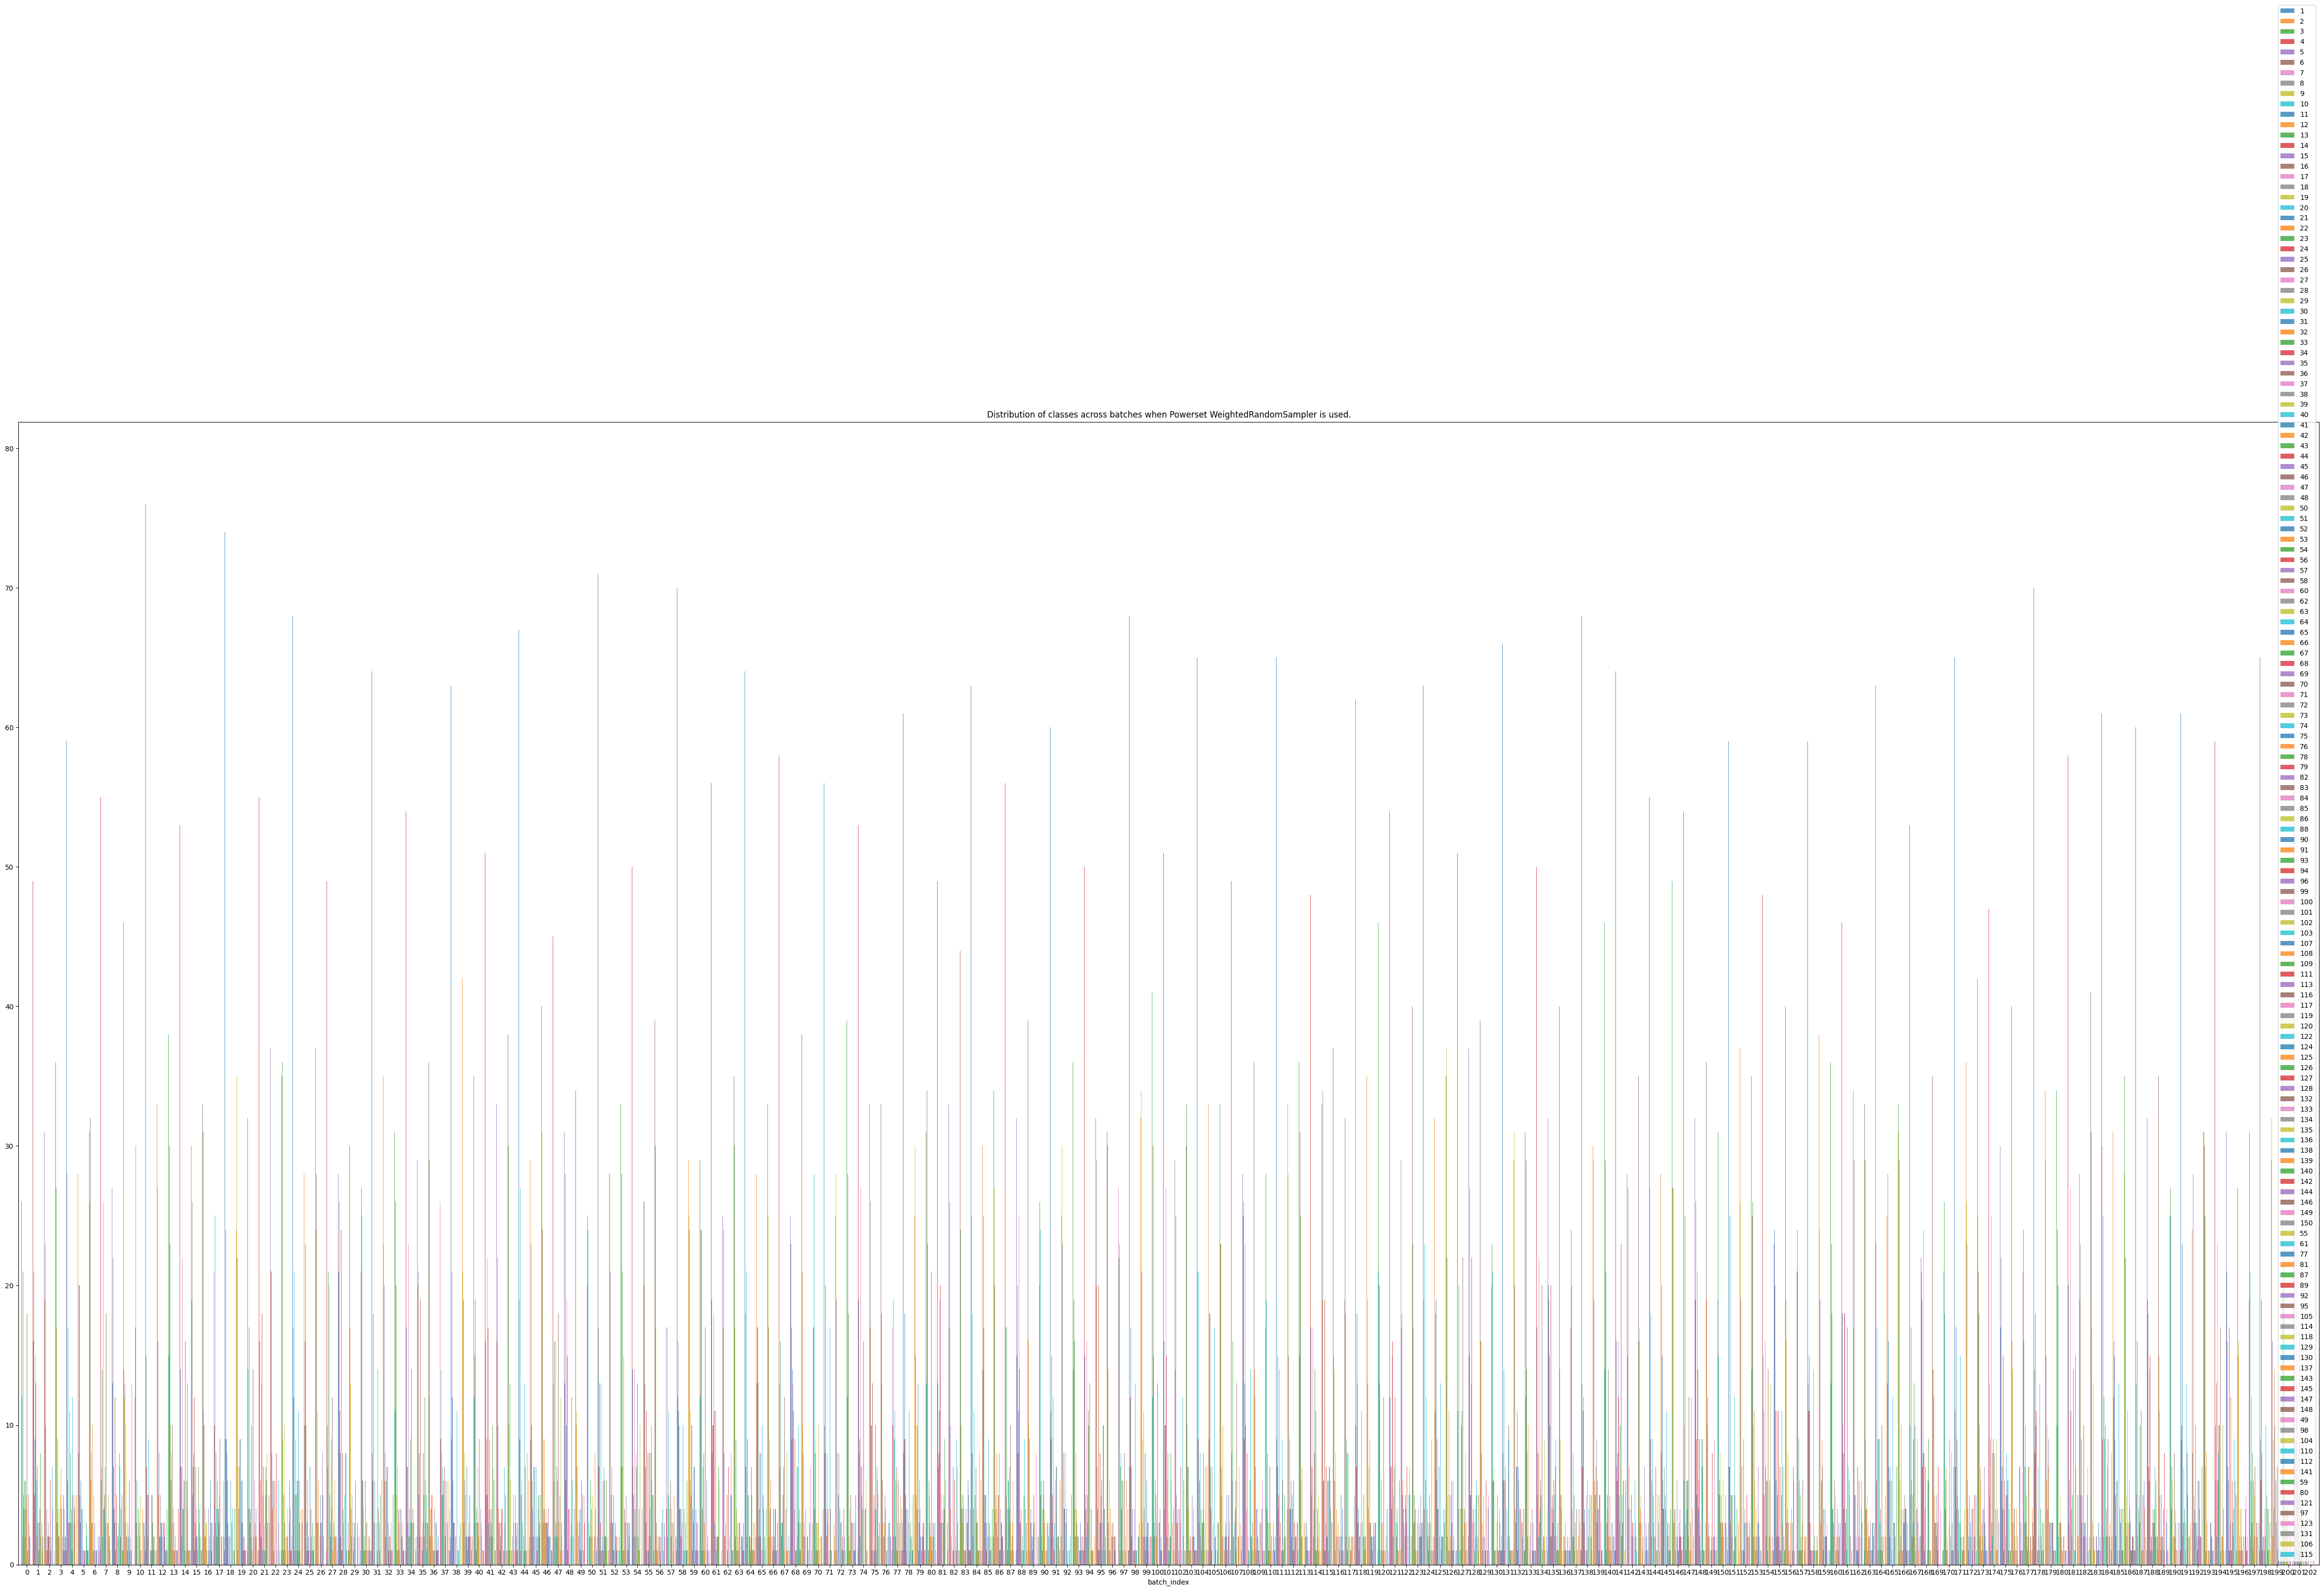

In [398]:
unique_label_combinations = weights_df.fillna(0).apply(
    lambda row: "".join(str(int(x)) for x in row), axis=1
)
label_counts = unique_label_combinations.value_counts()
powerset_probabilities = np.power(1 / label_counts, 3)
powerset_probabilities = powerset_probabilities / powerset_probabilities.sum()
powerset_sample_weights = unique_label_combinations.map(powerset_probabilities)


powerset_sampler = WeightedRandomSampler(
    weights=powerset_sample_weights, num_samples=len(weights_df), replacement=True
)
powerset_loader = DataLoader(
    SceneParsingStatsDataset(df),
    collate_fn=padding_collator,
    batch_size=100,
    sampler=powerset_sampler,
)

powerset_stats_df = summarize_batches(powerset_loader)

ax = powerset_stats_df.loc[:, 1:].plot(
    kind="bar", figsize=(60, 30), rot=0, alpha=0.75, logy=False, width=1
)
ax.set_title(
    "Distribution of classes across batches when Powerset WeightedRandomSampler is used."
)

Text(0.5, 1.0, 'Presence of Signal low prevalance 55,79,80,89,92,97,100,102,104,105,106,107,108,110,112,114,115,118,121,123,127,129,131,141 in Various Sampling Modes')

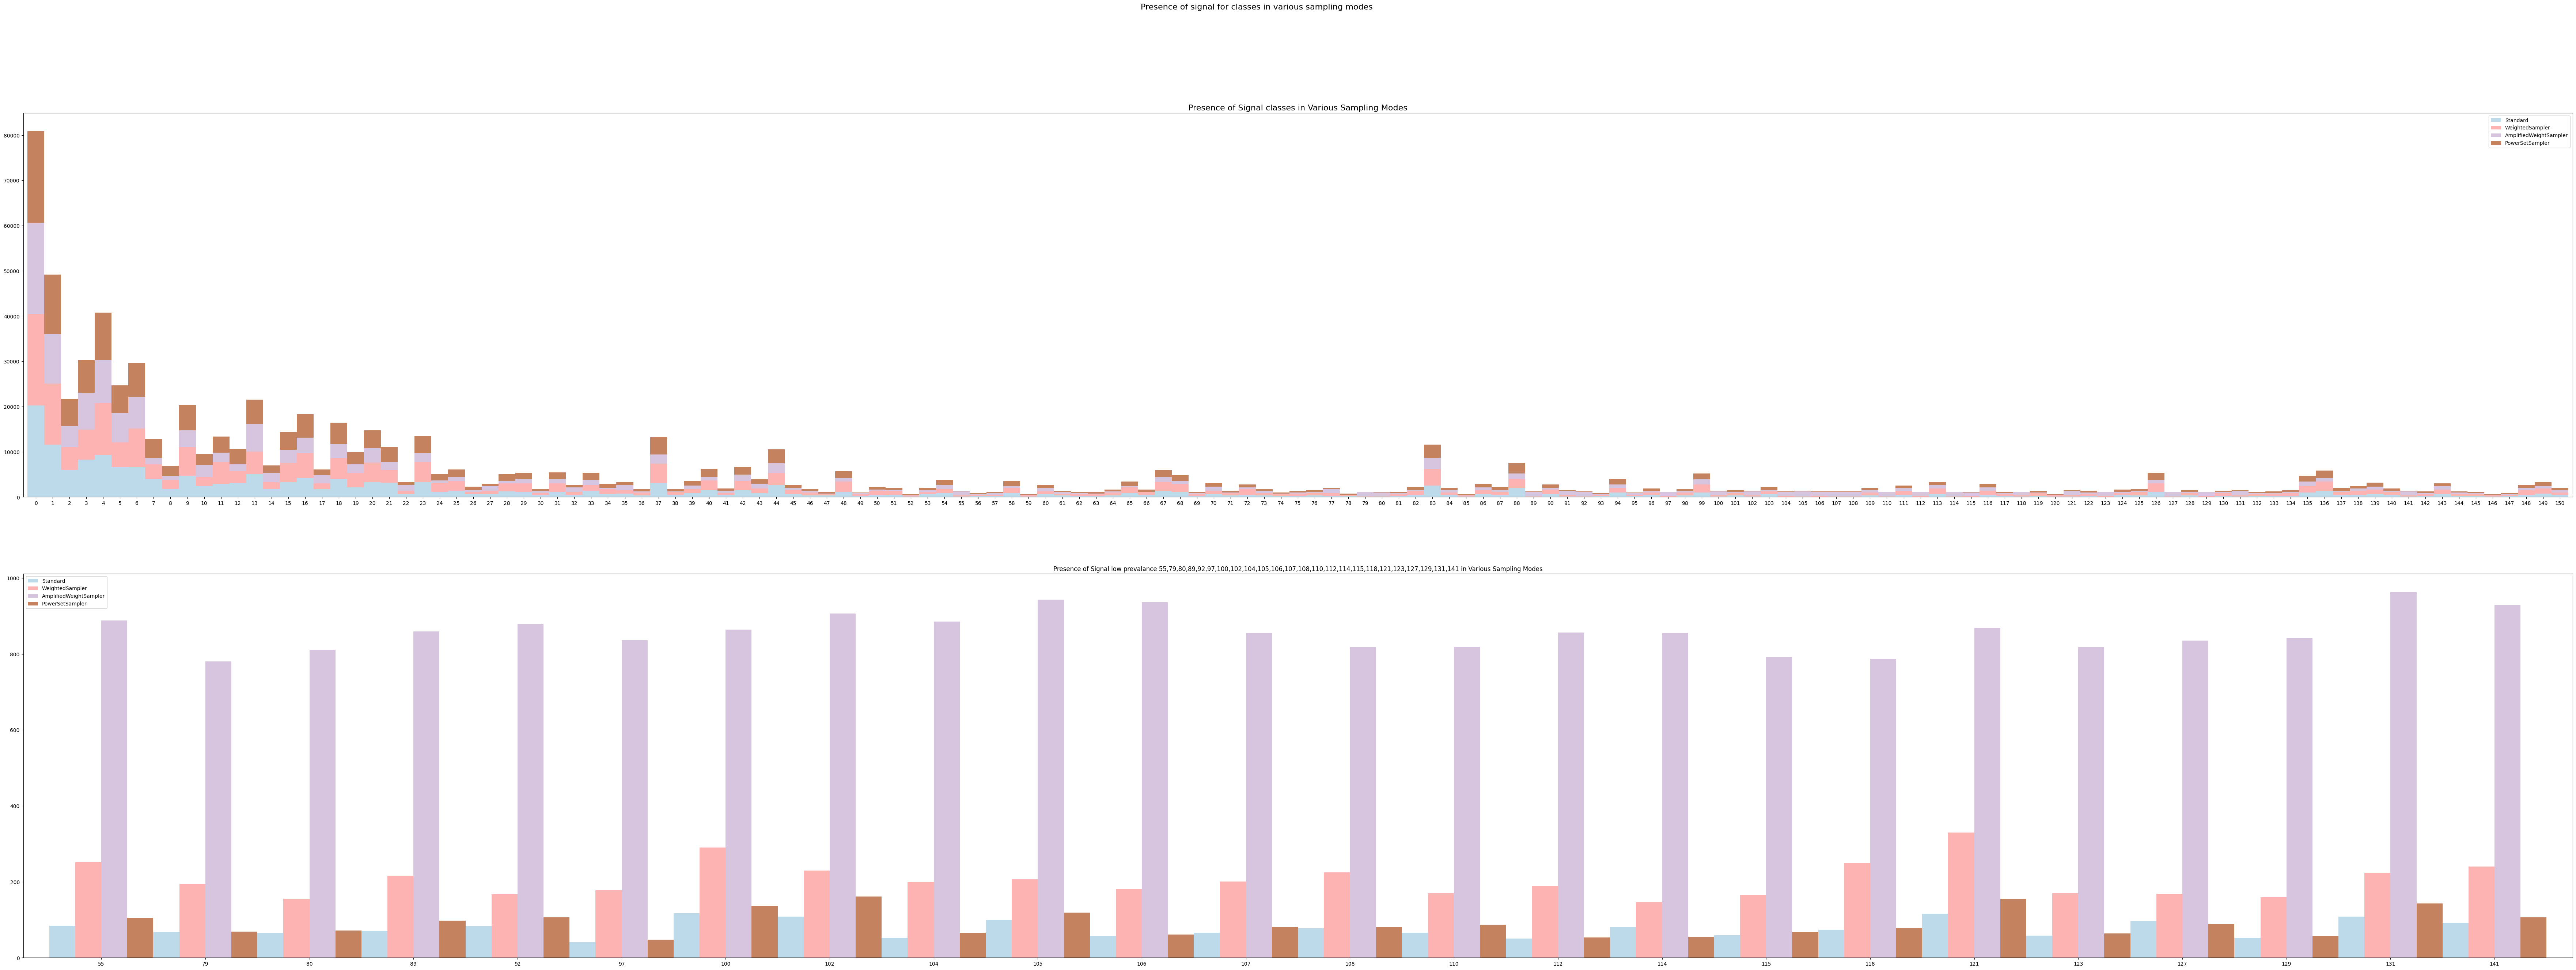

In [400]:
fig, axes = plt.subplots(nrows=2)
fig.suptitle(
    f"Presence of signal for classes in various sampling modes",
    fontsize=16,
)

plot_df = pd.DataFrame(
    [
        stats_df.sum(axis="rows").sort_index(),
        stats_weighted_df.sum(axis="rows").sort_index(),
        multiplier_stats_weighted_df.sum(axis="rows").sort_index(),
        powerset_stats_df.sum(axis="rows").sort_index(),
    ],
    index=["Standard", "WeightedSampler", "AmplifiedWeightSampler", "PowerSetSampler"],
).T
plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(90, 30),
    # logy=True,
    rot=0,
    alpha=0.75,
    width=1,
    colormap="Paired",
    ax=axes[0],
)
axes[0].set_title(
    f"Presence of Signal classes in Various Sampling Modes",
    fontsize=16,
)

plot_df.T[low_prevelance_class_ids].T.plot(
    kind="bar",
    figsize=(90, 30),
    rot=0,
    alpha=0.75,
    width=1,
    colormap="Paired",
    ax=axes[1],
)
axes[1].set_title(
    f"Presence of Signal low prevalance {','.join(map(str, low_prevelance_class_ids))} in Various Sampling Modes"
)

## Part 2: ML-SMOTE

In [386]:
from sklearn.neighbors import NearestNeighbors
import random
import numpy as np
import pandas as pd


def low_prevalance_classes(df: pd.DataFrame):
    _df = df.sum(axis="rows")
    _df.index = _df.index.astype(int)
    inverse_prevalance_per_label = np.array(_df.sort_index())
    inverse_prevalance_per_label = (
        max(inverse_prevalance_per_label) / inverse_prevalance_per_label
    )
    mean_inverse = inverse_prevalance_per_label.mean()
    return [
        cid for cid in _df.index if inverse_prevalance_per_label[cid] > mean_inverse
    ]


def idx_of_labels(df, tail_labels):
    return


def sample_with_mlsmote(source, target, n_sample):
    nbs = NearestNeighbors(n_neighbors=5, metric="euclidean", algorithm="kd_tree").fit(
        source
    )
    _, indices = nbs.kneighbors(source)
    n = len(indices)
    sampled_source = np.zeros((n_sample, source.shape[1]))
    sampled_target = np.zeros((n_sample, target.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n - 1)
        neighbour = random.choice(indices[reference, 1:])
        all_point = indices[reference]
        nn_df = target[target.index.isin(all_point)]
        ser = nn_df.sum(axis=0, skipna=True)
        sampled_target[i] = np.array([1 if val > 2 else 0 for val in ser])
        ratio = random.random()
        gap = source.loc[reference, :] - source.loc[neighbour, :]
        sampled_source[i] = np.array(source.loc[reference, :] + ratio * gap)
    sampled_source = pd.DataFrame(sampled_source, columns=source.columns)
    sampled_target = pd.DataFrame(sampled_target, columns=target.columns)
    sampled_source = pd.concat([source, sampled_source], axis=0)
    sampled_target = pd.concat([target, sampled_target], axis=0)
    return sampled_source, sampled_target


create_labels = lambda x: (np.random.random((1000)) > x) * 1.0
source = pd.DataFrame(np.random.random((10, 1000))).T
target = pd.DataFrame(
    [
        create_labels(0.5),
        create_labels(0.00005),
        create_labels(0.25),
        create_labels(0.01),
        create_labels(0.0001),
    ]
).T

# Obtain low prevalance findings
tail_labels = low_prevalance_classes(target)
# Obtain indices for low prevalance findings
idices_of_low_prevalance = list(
    target.index[target[tail_labels].sum(axis="columns") > 0.0]
)
candidate_target = target[target.index.isin(idices_of_low_prevalance)].reset_index(
    drop=True
)
candidate_source = source[target.index.isin(idices_of_low_prevalance)].reset_index(
    drop=True
)
sampled_source, sampled_target = sample_with_mlsmote(
    source=candidate_source, target=candidate_target, n_sample=50
)